In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


class TrafficSignDetector:
    def __init__(self, images_dir, train_images_dir):
        """
        Initialize the TrafficSignDetector with directories for images.

        :param images_dir: Path to the root image directory
        :param train_images_dir: Path to the training images subdirectory
        """
        self.images_dir = images_dir
        self.train_images_dir = train_images_dir

        # Placeholder for image dimensions and processing steps
        self.height = None
        self.width = None
        self.gray_image = None
        self.histofram_eq_image = None
        self.blurred_image = None
        self.thresholded_image = None
        self.edges = None
        self.eroded_image = None
        self.filtered_components = None
        self.output_image = None
        self.circles = None
        self.detected_plates = []

    def process_image(self, image_name):
        """
        Process an image through the detection pipeline.
        
        :param image_name: Filename of the image to process
        """
        # 1. Load and convert to grayscale
        image_path = os.path.join(self.images_dir, self.train_images_dir, image_name)
        self.gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        self.height, self.width = self.gray_image.shape
        

        # 2. Gaussian blur
        kernel_size = (self.width // 50, self.height // 50)  # Relative kernel size
        kernel_size = (max(3, kernel_size[0] | 1), max(3, kernel_size[1] | 1))  # Ensure odd size
        self.blurred_image = cv2.GaussianBlur(self.gray_image, kernel_size, 0)

        

        # 3. Thresholding
        self.thresholded_image = cv2.adaptiveThreshold(
                self.blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 2
                )

        
        # 4. Edge detection

        #make self.edges the negatice of the self.thresholded_image
        self.edges = cv2.bitwise_not(self.thresholded_image)
        
        
        # Connected components analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(self.edges, 8, cv2.CV_32S)
        self.connected_component_image = labels.copy()
        self.filtered_components = np.zeros(self.edges.shape, dtype=np.uint8)
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] > 1000:
                self.filtered_components[labels == i] = 255
                

        # 5. Morphological operations
        kernel_size = (self.width // 100, self.height // 100)  # Relative kernel size
        kernel_size = (max(3, kernel_size[0]), max(3, kernel_size[1]))  # Ensure minimum size
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
        dilated_image =   cv2.dilate(self.filtered_components, kernel, iterations=1)
        self.eroded_image = cv2.erode(dilated_image, kernel, iterations=1)


        # 6. Circle detection (Hough Transform)
        min_radius = min(self.height // 9, self.width // 9)  # Relative to image height
        max_radius = max(self.height // 2, self.width // 2)
        self.circles = cv2.HoughCircles(
            self.eroded_image,
            cv2.HOUGH_GRADIENT_ALT,
            dp=1,
            minDist=min(self.height // 100, self.width // 100),
            param1=50,
            param2=0.7,
            minRadius=min_radius,
            maxRadius=max_radius,
        )

        # 7. Remove overlapping circles
        self.remove_overlapping_circles()

        # 8. Draw detected circles and extract plates
        self.output_image = cv2.cvtColor(self.gray_image, cv2.COLOR_GRAY2BGR)
        if self.circles is not None:
            self.circles = np.uint16(np.around(self.circles))
            for circle in self.circles[0, :]:
                x, y, r = circle
                cv2.circle(self.output_image, (x, y), r, (0, 255, 0), 2)
                cropped_plate = self.gray_image[max(0, y - r) : min(self.height, y + r), max(0, x - r) : min(self.width, x + r)]
                self.detected_plates.append(cropped_plate)

    def remove_overlapping_circles(self, overlap_threshold=0.3):
        """
        Remove overlapping circles from the list based on a threshold.

        :param overlap_threshold: The minimum overlap ratio to consider two circles as overlapping
        """
        if self.circles is not None:
            valid_circles = []
            for i, circle1 in enumerate(self.circles[0, :]):
                x1, y1, r1 = circle1
                is_overlapping = False
                
                # If valid_circles is empty, we can add the first circle directly
                if len(valid_circles) == 0:
                    valid_circles.append(circle1)
                    continue
                
                for circle2 in valid_circles:
                    x2, y2, r2 = circle2
                    # Calculate distance between centers
                    distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                    print(x1, y1, r1, x2, y2, r2, distance)
                    # Check if the circles overlap more than the threshold
                    print(distance, (r1 + r2) * (1 - overlap_threshold))
                    if distance < (r1 + r2) * (1 - overlap_threshold):
                        is_overlapping = True
                        break

                if not is_overlapping:
                    valid_circles.append(circle1)
            
            # Update self.circles with the filtered non-overlapping circles
            self.circles = np.array([valid_circles], dtype=np.uint16)


    def visualize_results(self):
        """
        Visualize intermediate results and detected plates.
        """
        titles = [
            "Original Image",
            "Gaussian Blur",
            "Thresholded Image",
            "Edges",
            "Connected Components",
            "Filtered Components",
            "Morphological Image",
            "Detected Circles",
        ]
        images = [
            self.gray_image,
            self.blurred_image,
            self.thresholded_image,
            self.edges,
            self.connected_component_image,
            self.filtered_components ,
            self.eroded_image,
            self.output_image,
        ]

        plt.figure(figsize=(20, 10))
        for i, (title, img) in enumerate(zip(titles, images), 1):
            if img is not None:
                plt.subplot(2, 4, i)
                plt.title(title)
                cmap = "gray" if len(img.shape) == 2 else None
                plt.imshow(img, cmap=cmap)
                #plt.axis("off")

        # Visualize detected plates
        for i, plate in enumerate(self.detected_plates, 1):
            plt.figure(figsize=(5, 5))
            plt.title(f"Detected Plate {i}")
            plt.imshow(plate, cmap="gray")
            #plt.axis("off")
            plt.show()

        plt.tight_layout()
        plt.show()


libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


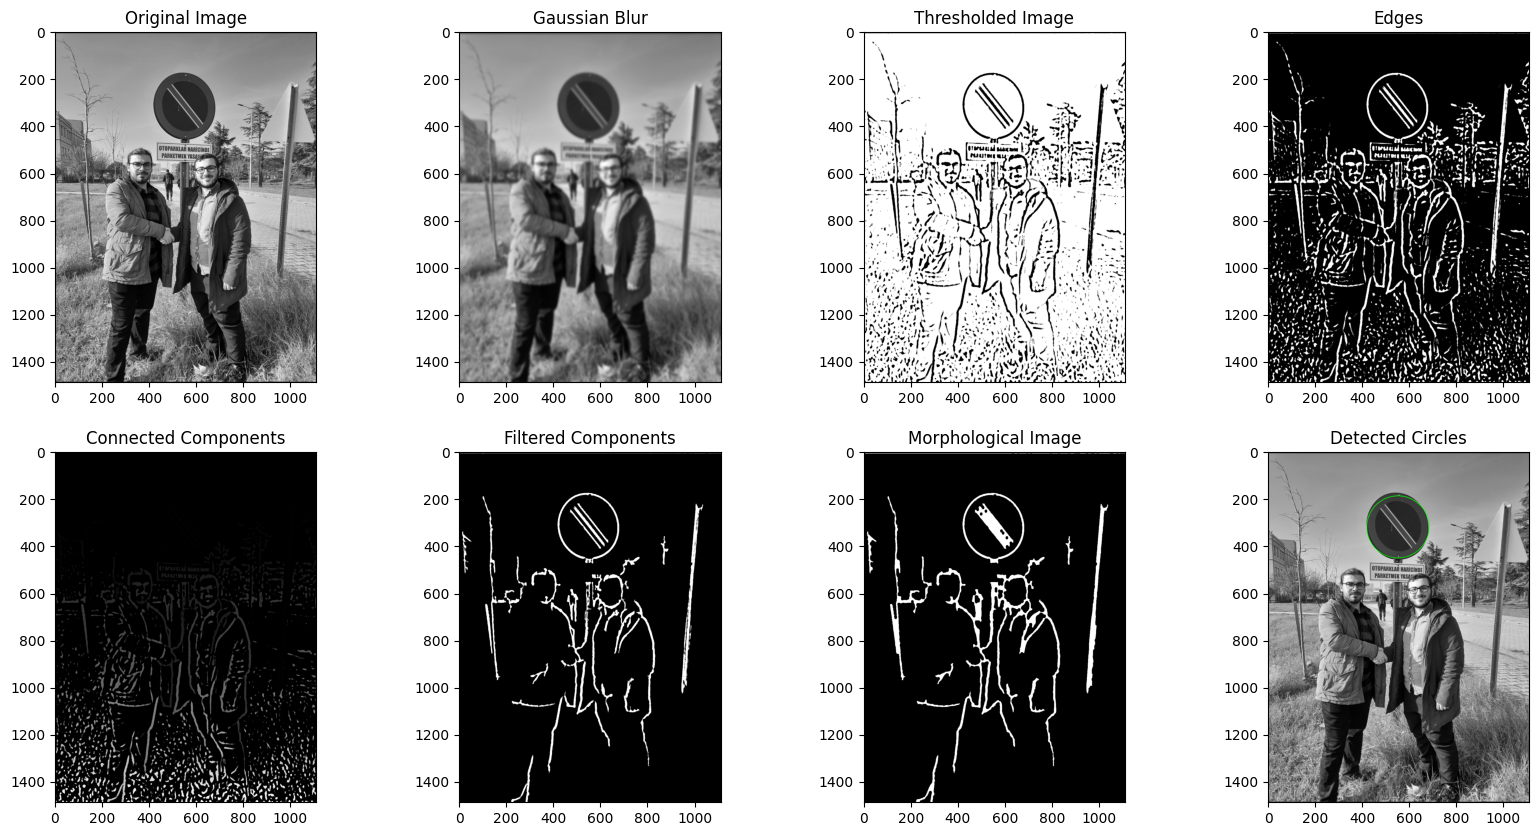

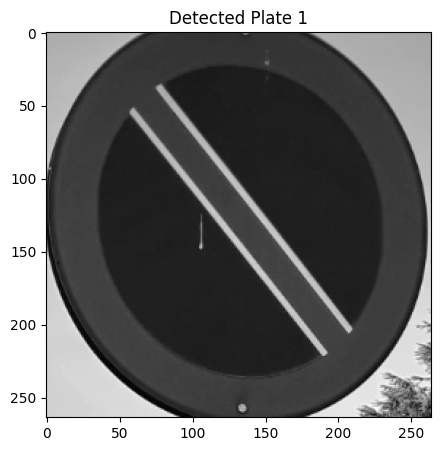

<Figure size 640x480 with 0 Axes>

In [52]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="train")
detector.process_image("train_hard_2.png")
detector.visualize_results()

73.0 65.0 38.65793 76.0 73.0 44.735092 8.5440035
8.5440035 58.375114
83.0 78.0 40.266117 76.0 73.0 44.735092 8.602325
8.602325 59.500843
81.0 81.0 47.114094 76.0 73.0 44.735092 9.433981
9.433981 64.294426
73.0 73.0 40.4775 76.0 73.0 44.735092 3.0
3.0 59.648815
84.0 60.0 37.62356 76.0 73.0 44.735092 15.264338
15.264338 57.65106
65.0 70.0 37.419395 76.0 73.0 44.735092 11.401754
11.401754 57.50814
63.0 71.0 47.1356 76.0 73.0 44.735092 13.152946
13.152946 64.30949
63.0 78.0 35.335884 76.0 73.0 44.735092 13.928389
13.928389 56.049683


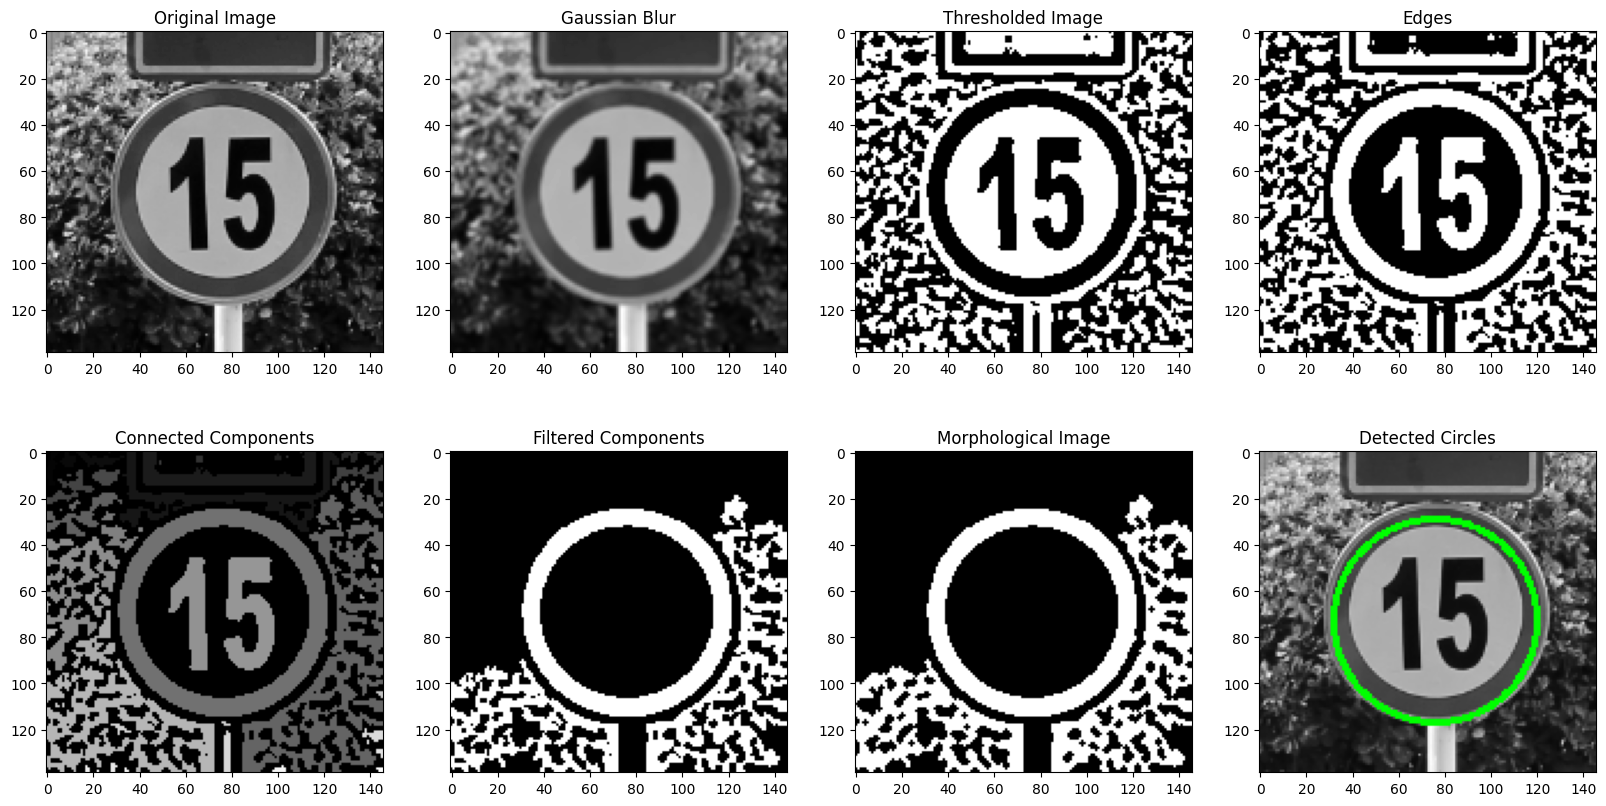

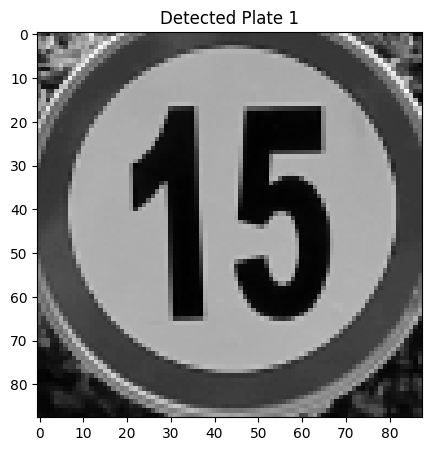

<Figure size 640x480 with 0 Axes>

In [53]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="train")
detector.process_image("train_easy_1.png")
detector.visualize_results()

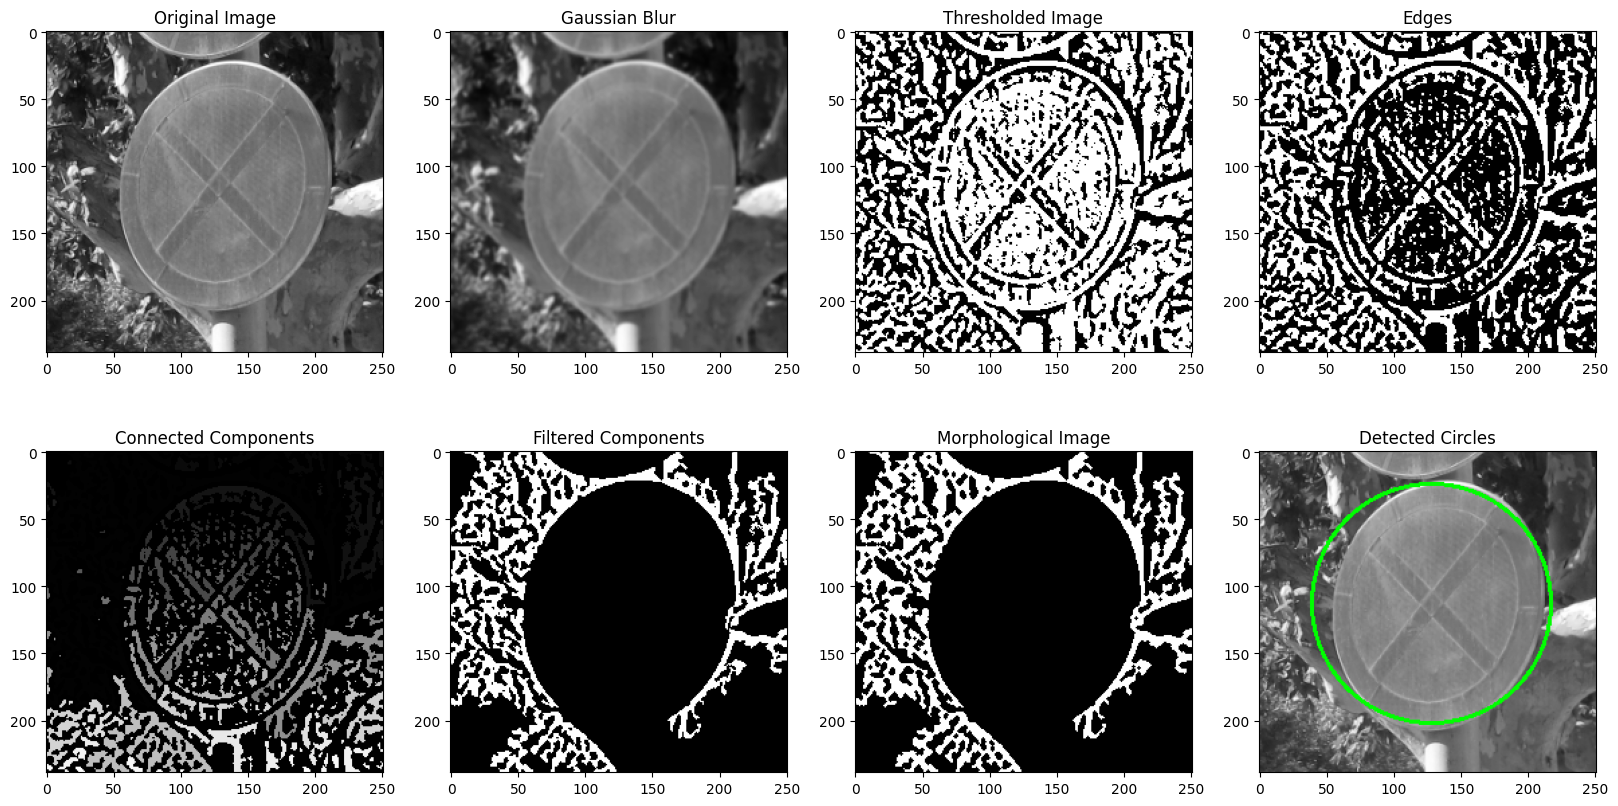

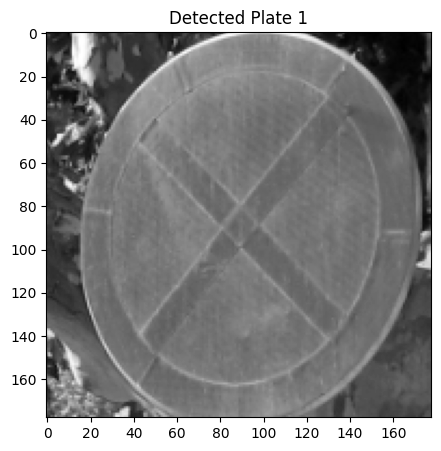

<Figure size 640x480 with 0 Axes>

In [54]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="train")
detector.process_image("train_easy_2.png")
detector.visualize_results()

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


455.0 285.0 206.22142 426.0 281.0 223.4534 29.274563
29.274563 300.77237
432.0 241.0 242.63602 426.0 281.0 223.4534 40.4475
40.4475 326.26257
414.0 289.0 199.4522 426.0 281.0 223.4534 14.422205
14.422205 296.0339
426.0 281.0 187.03519 426.0 281.0 223.4534 0.0
0.0 287.342
455.0 257.0 186.09885 426.0 281.0 223.4534 37.64306
37.64306 286.68655
371.0 302.0 164.53976 426.0 281.0 223.4534 58.872746
58.872746 271.5952
388.0 319.0 178.79573 426.0 281.0 223.4534 53.740116
53.740116 281.5744
482.0 302.0 187.98744 426.0 281.0 223.4534 59.808025
59.808025 288.0086
482.0 302.0 165.51337 426.0 281.0 223.4534 59.808025
59.808025 272.27673
396.0 307.0 153.03691 426.0 281.0 223.4534 39.698868
39.698868 263.5432
351.0 255.0 141.96979 426.0 281.0 223.4534 79.37884
79.37884 255.79623
390.0 259.0 146.33267 426.0 281.0 223.4534 42.190044
42.190044 258.85025
429.0 333.0 141.395 426.0 281.0 223.4534 52.086468
52.086468 255.39388


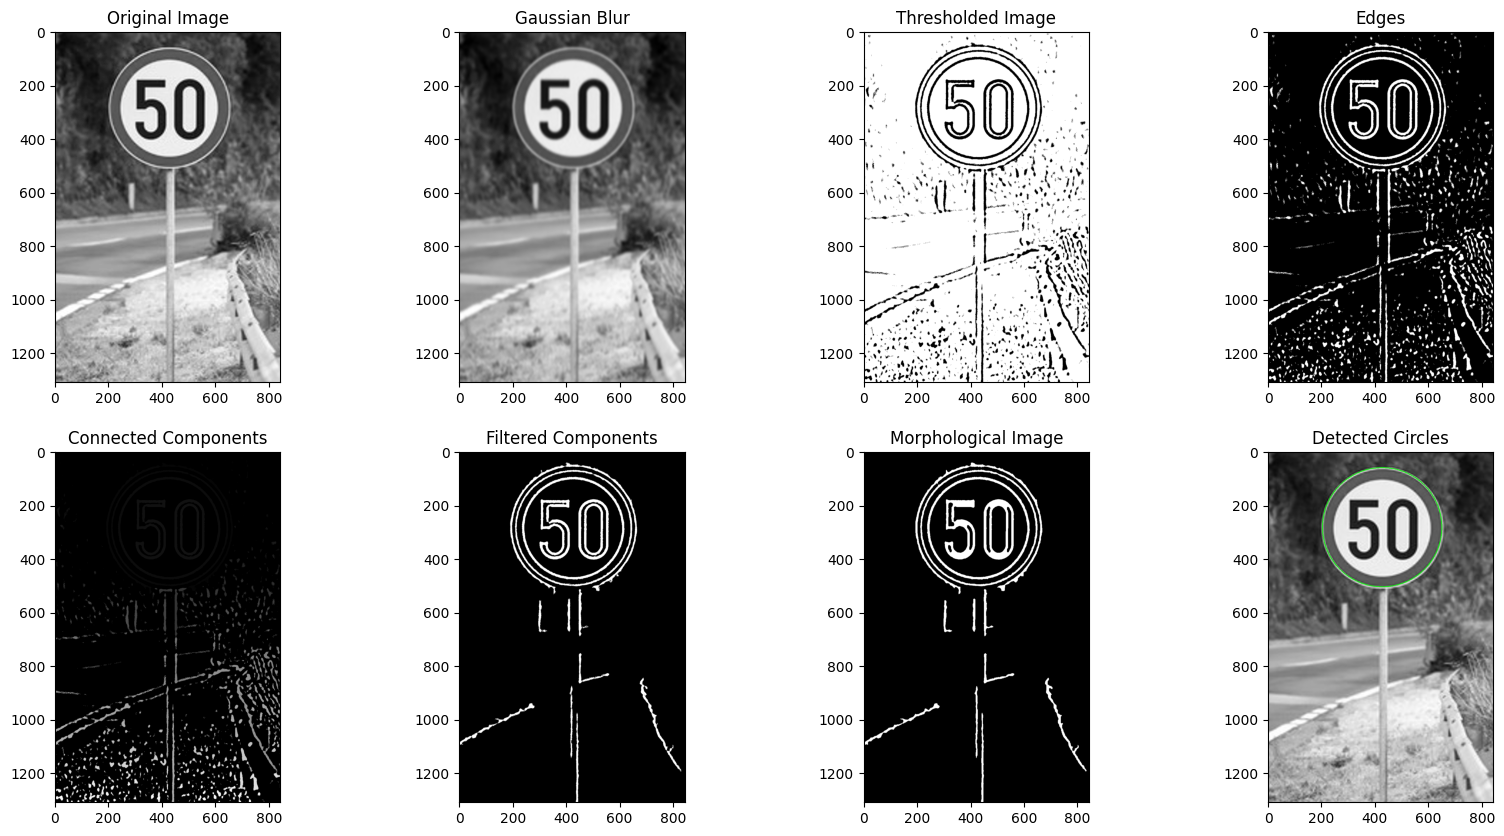

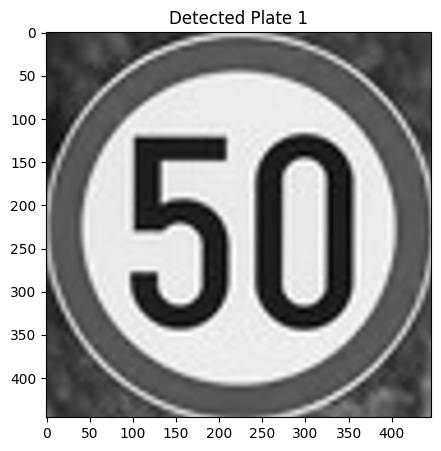

<Figure size 640x480 with 0 Axes>

In [55]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="train")
detector.process_image("train_middle_1.png")
detector.visualize_results()

173.0 155.0 77.567635 174.0 133.0 92.05818 22.022715
22.022715 118.738075
173.0 123.0 80.27097 174.0 133.0 92.05818 10.049875
10.049875 120.63041
179.0 151.0 72.06938 174.0 133.0 92.05818 18.681541
18.681541 114.88929
156.0 140.0 67.19145 174.0 133.0 92.05818 19.313208
19.313208 111.47474
156.0 133.0 85.32547 174.0 133.0 92.05818 18.0
18.0 124.16856
198.0 155.0 68.20257 174.0 133.0 92.05818 32.55764
32.55764 112.18252
173.0 155.0 93.03303 174.0 133.0 92.05818 22.022715
22.022715 129.56384
151.0 134.0 61.836216 174.0 133.0 92.05818 23.021729
23.021729 107.726074
158.0 162.0 63.68065 174.0 133.0 92.05818 33.12099
33.12099 109.01718
145.0 163.0 58.015503 174.0 133.0 92.05818 41.725292
41.725292 105.051575
192.0 159.0 60.999317 174.0 133.0 92.05818 31.622776
31.622776 107.14024
140.0 143.0 60.074932 174.0 133.0 92.05818 35.44009
35.44009 106.49318
173.0 155.0 46.94709 174.0 133.0 92.05818 22.022715
22.022715 97.303696
166.0 143.0 48.659534 174.0 133.0 92.05818 12.806249
12.806249 98.502396

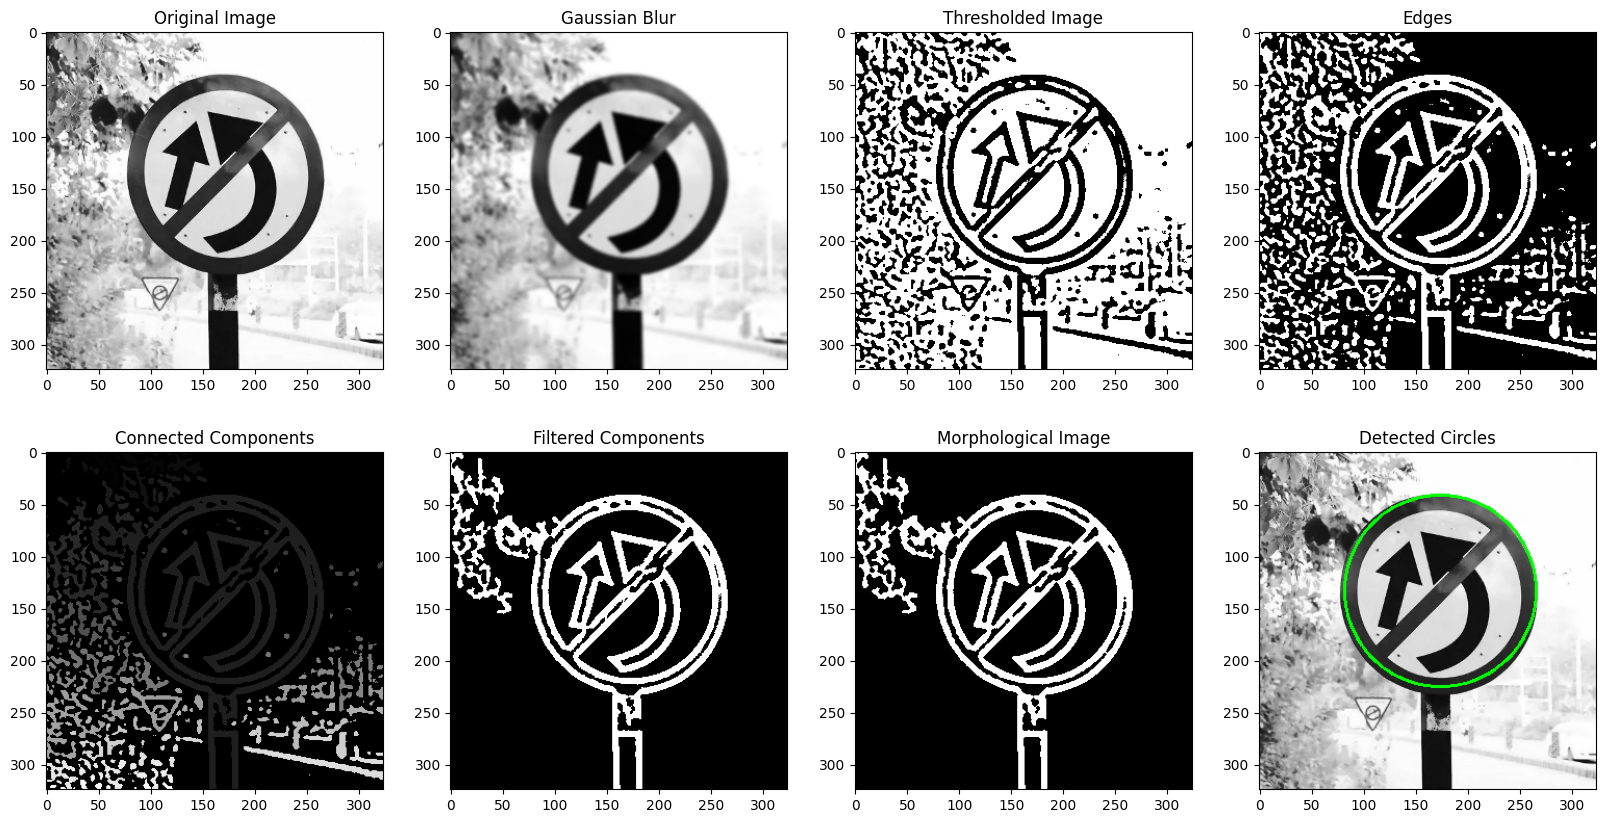

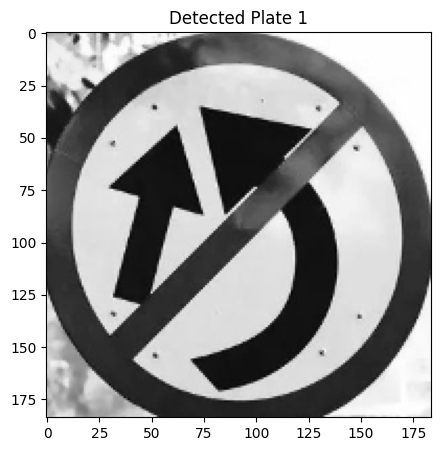

<Figure size 640x480 with 0 Axes>

In [56]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="train")
detector.process_image("train_middle_2.png")
detector.visualize_results()

# Test

186.0 176.0 154.06764 199.0 169.0 141.41197 14.764823
14.764823 206.83572
186.0 176.0 122.575035 199.0 169.0 141.41197 14.764823
14.764823 184.7909
173.0 187.0 144.02798 199.0 169.0 141.41197 31.622776
31.622776 199.80795
225.0 185.0 147.96416 199.0 169.0 141.41197 30.528675
30.528675 202.5633
186.0 147.0 123.486465 199.0 169.0 141.41197 25.553865
25.553865 185.42891
176.0 158.0 125.620514 199.0 169.0 141.41197 25.495098
25.495098 186.92273
215.0 176.0 124.20482 199.0 169.0 141.41197 17.464249
17.464249 185.93175
192.0 206.0 131.56412 199.0 169.0 141.41197 37.65634
37.65634 191.08325
243.0 180.0 103.18427 199.0 169.0 141.41197 45.35416
45.35416 171.21738


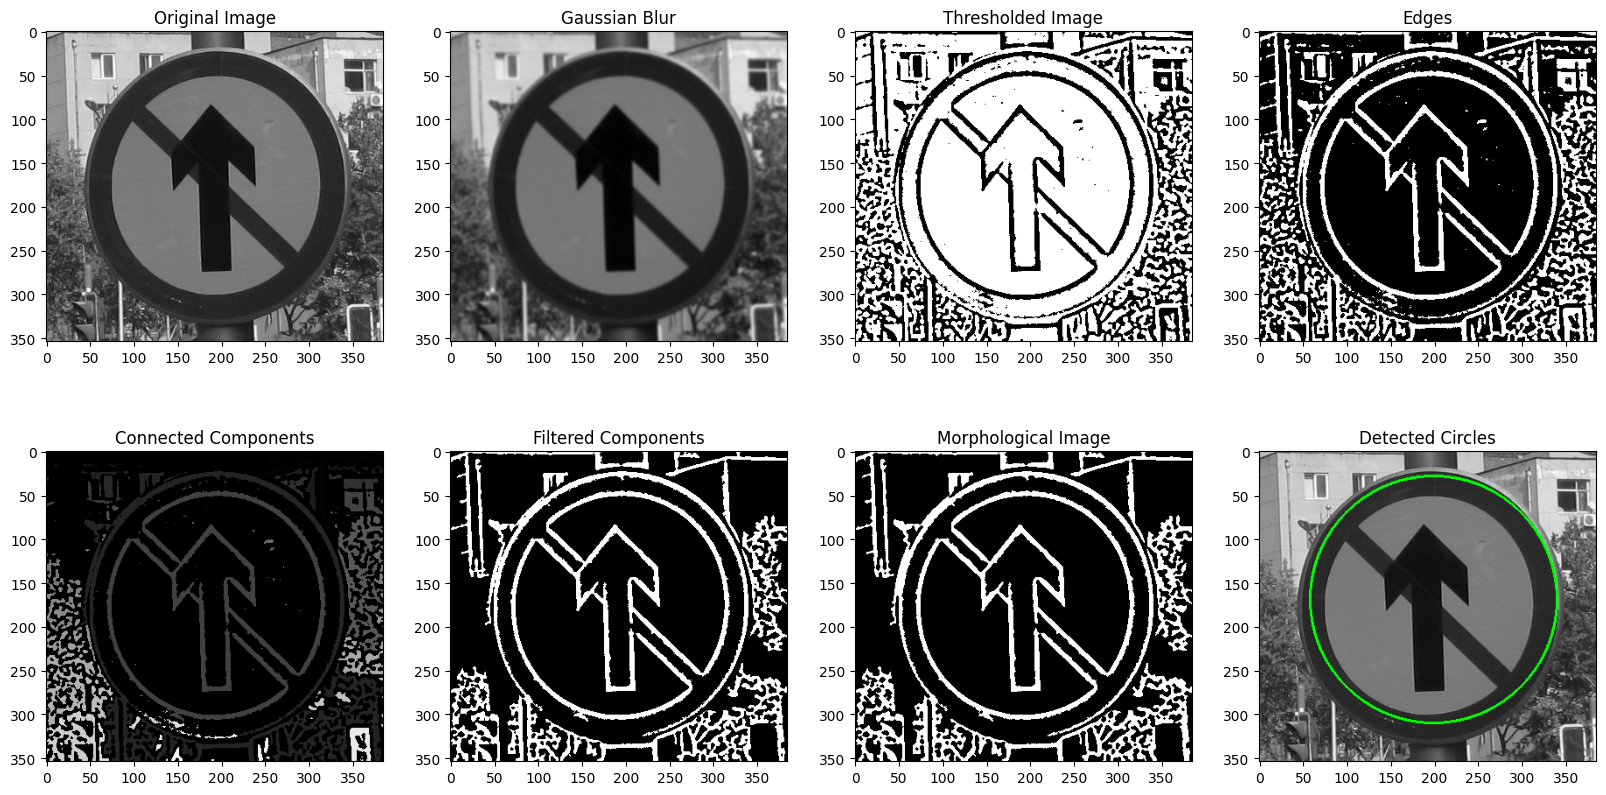

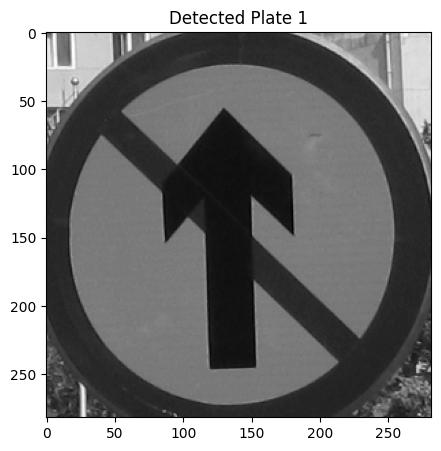

<Figure size 640x480 with 0 Axes>

In [57]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="test")
detector.process_image("test_easy_1.png")
detector.visualize_results()

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


241.0 329.0 207.65027 742.0 750.0 234.68204 654.40204
654.40204 309.6326
247.0 768.0 216.63286 742.0 750.0 234.68204 495.32718
495.32718 315.9204
247.0 768.0 216.63286 241.0 329.0 207.65027 439.041
439.041 296.9982
239.0 349.0 190.59659 742.0 750.0 234.68204 643.28064
643.28064 297.69504
239.0 349.0 190.59659 241.0 329.0 207.65027 20.09975
20.09975 278.7728
773.0 760.0 216.1656 742.0 750.0 234.68204 32.572994
32.572994 315.59335
706.0 300.0 208.3629 742.0 750.0 234.68204 451.4377
451.4377 310.13144
706.0 300.0 208.3629 241.0 329.0 207.65027 465.9034
465.9034 291.20923
706.0 300.0 208.3629 247.0 768.0 216.63286 655.51886
655.51886 297.49704
742.0 750.0 183.51651 742.0 750.0 234.68204 0.0
0.0 292.73898
729.0 295.0 228.58661 742.0 750.0 234.68204 455.18567
455.18567 324.28806
729.0 295.0 228.58661 241.0 329.0 207.65027 489.18298
489.18298 305.3658
729.0 295.0 228.58661 247.0 768.0 216.63286 675.31696
675.31696 311.65363
729.0 295.0 228.58661 706.0 300.0 208.3629 23.537205
23.537205 305.86

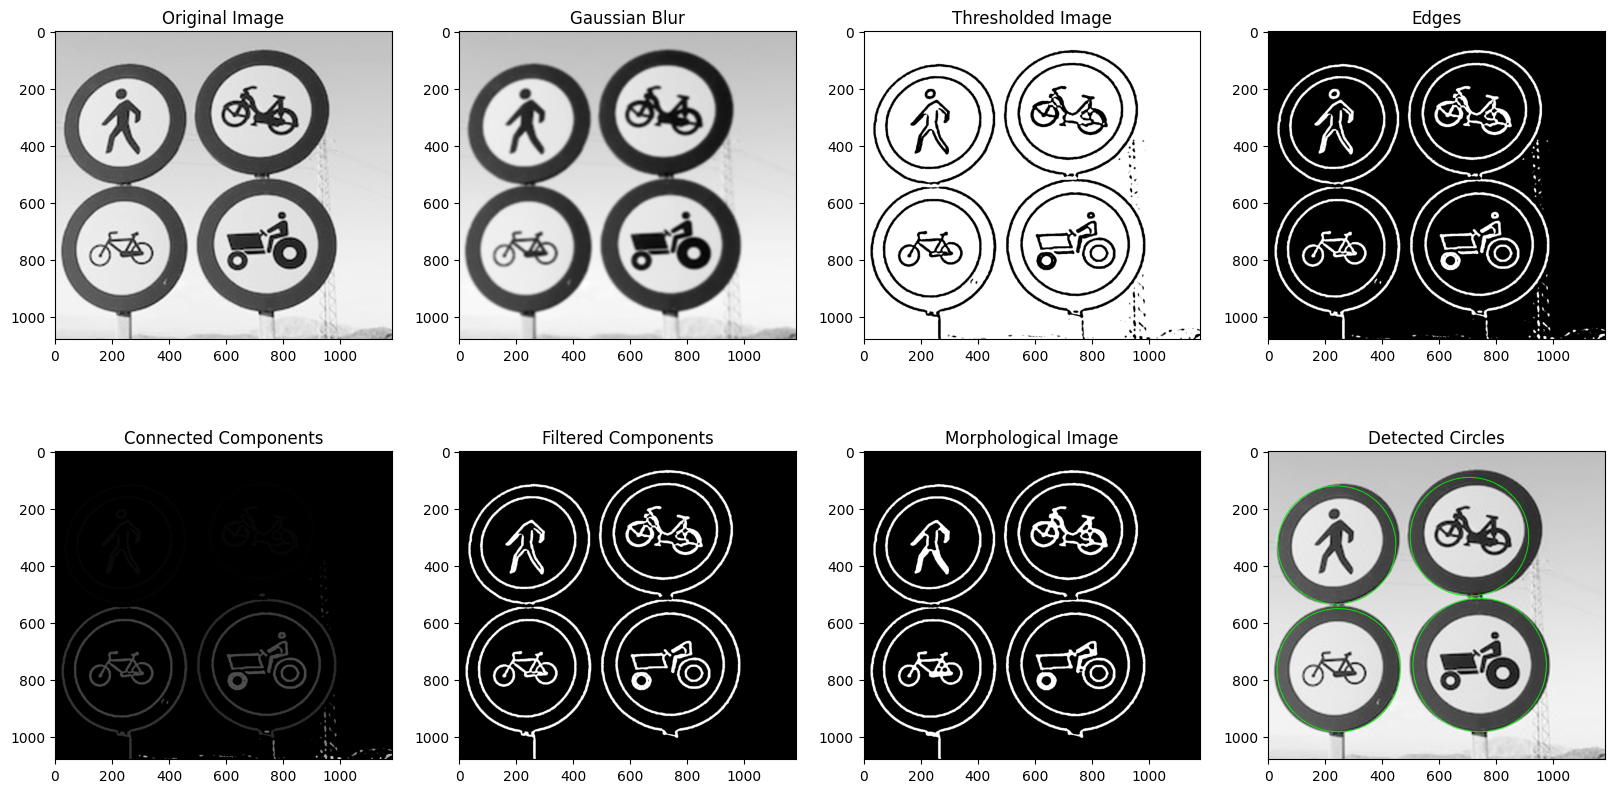

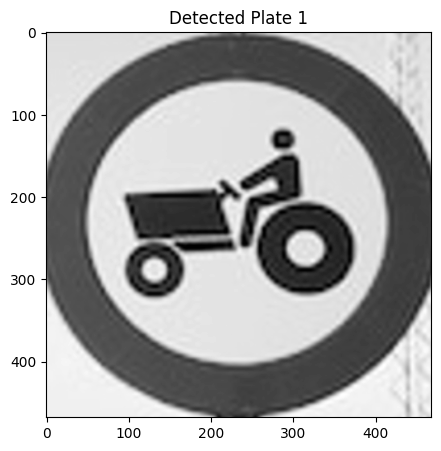

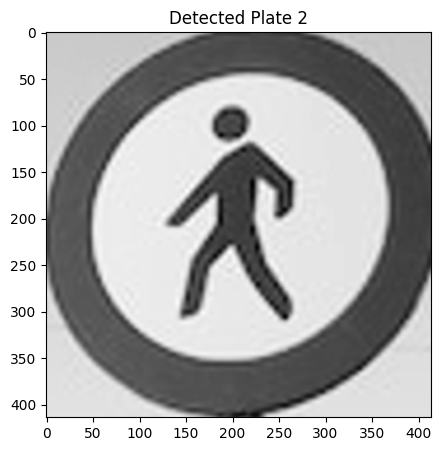

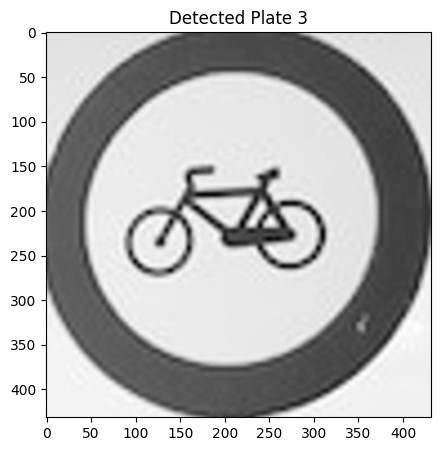

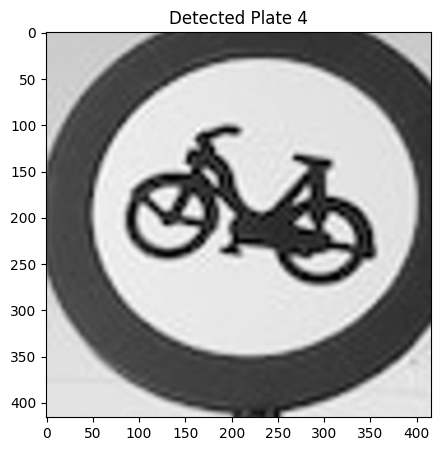

<Figure size 640x480 with 0 Axes>

In [58]:
detector = TrafficSignDetector(images_dir="images_gray", train_images_dir="test")
detector.process_image("test_easy_2.png")
detector.visualize_results()